In [121]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

import time
import random


In [122]:
# train data
X_TRAIN = np.load("Xtrain_Classification_Part1.npy")
Y_TRAIN = np.load("Ytrain_Classification_Part1.npy")

# test data
X_TEST = np.load("Xtest_Classification_Part1.npy")


In [123]:
# reshape train data and convert to tensor
X_TRAIN = X_TRAIN.reshape(X_TRAIN.shape[0], 1, 50, 50) / 255
Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], 1)

X_TRAIN_tensor = torch.Tensor(X_TRAIN).float()
Y_TRAIN_tensor = torch.Tensor(Y_TRAIN).float()

# reshape test data and convert to tensor
X_TEST = X_TEST.reshape(X_TEST.shape[0], 1, 50, 50) / 255

X_TEST_tensor = torch.Tensor(X_TRAIN).float()

In [124]:
# split the data
trainX, devX, trainY, devY = train_test_split(X_TRAIN_tensor, Y_TRAIN_tensor)

# convert to dataloader
trainSet = TensorDataset(trainX, trainY)
devSet = TensorDataset(devX, devY)

trainLoader = DataLoader(trainSet, batch_size=64)
devLoader = DataLoader(devSet, batch_size=64)


In [125]:
def createGervasio():
    class gervasio(nn.Module):
        def __init__(self) -> None:
            super().__init__()

            self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=1, padding=1)
            size = np.floor((np.floor((50 + 2 * 1 -4) / 1) + 1) / 2)

            self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=1)
            size = np.floor((np.floor((size + 2 * 1 - 4) / 1) + 1) / 2)

            expectSize = np.floor((size + 2 * 0 - 1) / 1) + 1
            expectSize = 32 * int(expectSize ** 2)

            self.fc1 = nn.Linear(expectSize, 64)

            self.out = nn.Linear(64, 1)

            # size = np.floor((np.floor((50 + 2 * 1 - 3) / 1) + 1))
            # size = np.floor((np.floor((size + 2 * 1 - 3) / 1) + 1) / 2)
            # size = np.floor((np.floor((size + 2 * 1 - 3) / 1) + 1))
            # size = np.floor((np.floor((size + 2 * 1 - 3) / 1) + 1) / 2)
            # size = np.floor((np.floor((size + 2 * 1 - 3) / 1) + 1))
            # size = np.floor((np.floor((size + 2 * 1 - 3) / 1) + 1) / 2)
            # size = np.floor((np.floor((size + 2 * 1 - 3) / 1) + 1))
            # size = np.floor((np.floor((size + 2 * 1 - 3) / 1) + 1) / 2)
            # expectSize = np.floor((size + 2 * 0 - 1) / 1) + 1
            # expectSize = 512 * int(expectSize ** 2)

            # self.network = nn.Sequential(
            #     nn.Conv2d(1,32,kernel_size = 3, stride = 1, padding = 1),
            #     nn.ReLU(),
            #     nn.Conv2d(32,64,kernel_size = 3, stride = 1 ,padding = 1),
            #     nn.ReLU(),
            #     nn.MaxPool2d(2,2),    #out: 64 x 32 x 32
                
            #     nn.Conv2d(64,128,kernel_size = 3, stride = 1 , padding = 1),
            #     nn.ReLU(),
            #     nn.Conv2d(128,128,kernel_size = 3, stride = 1 ,padding = 1),
            #     nn.ReLU(),
            #     nn.MaxPool2d(2,2),    #out : 128 x 16 x 16
                
            #     nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 1),
            #     nn.ReLU(),
            #     nn.Conv2d(256,256,kernel_size = 3, stride = 1 ,padding = 1),
            #     nn.ReLU(),
            #     nn.MaxPool2d(2,2),    #out: 256 x 8 x 8
                
            #     nn.Conv2d(256,512,kernel_size = 3, stride = 1, padding = 1),
            #     nn.ReLU(),
            #     nn.Conv2d(512,512,kernel_size = 3, stride = 1 ,padding = 1),
            #     nn.ReLU(),
            #     nn.MaxPool2d(2,2),   #out : 512 x 8 x 8
                
            #     nn.Flatten(),
            #     nn.Linear(expectSize,8192),
            #     nn.ReLU(),
                        
            #     nn.Linear(8192,1024),
            #     nn.ReLU(),
                
            #     nn.Linear(1024,512),
            #     nn.ReLU(),

            #     nn.Linear(512,128),
            #     nn.ReLU(),

            #     nn.Linear(128,32),
            #     nn.ReLU(),

            #     nn.Linear(32,1),
            #     nn.Sigmoid()
            # )

        def forward(self, x):
            x = F.relu(F.avg_pool2d(self.conv1(x), 2))

            x = F.relu(F.avg_pool2d(self.conv2(x), 2))

            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))

            x = F.relu(self.fc1(x))

            x = torch.sigmoid(self.out(x))

            return x

            # return self.network(x)

    # criar o gervasio
    Gervasio = gervasio()

    # loss func
    lossF = nn.BCELoss()  # binary cross entropy

    optimizer = torch.optim.Adam(Gervasio.parameters(), lr=0.001)

    return Gervasio, lossF, optimizer


In [126]:
def trainGervasio():
    # number of epochs
    numepochs = 12

    # create a new model
    Gervasio, lossfun, optimizer = createGervasio()

    # initialize losses and accuracies
    trainLosses = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    devLosses = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        Gervasio.train()
        batchAcc = []
        batchLoss = []
        for X, Y in trainLoader:

            # forward pass and loss
            Y_pred = Gervasio(X)
            loss = lossfun(Y_pred, Y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            match = ((Y_pred >= 0.5).float() == Y).float()
            batchAcc.append(match)  # add to list of accuracies

        # now that we've trained through the batches, get their average training accuracy
        trainAcc[epochi] = 100*np.mean(np.array(batchAcc[0].tolist()))

        # and get average losses across the batches
        trainLosses[epochi] = np.mean(batchLoss)
        
        # test accuracy
        Gervasio.eval()
        batchAcc = []
        batchLoss = []
        for X, Y in devLoader:
            with torch.no_grad():  # deactivates autograd
                Y_pred = Gervasio(X)

            loss = lossfun(Y_pred, Y)
            batchLoss.append(loss.item())

            # compute accuracy
            match = ((Y_pred >= 0.5).float() == Y).float()
            batchAcc.append(match)  # add to list of accuracies
            
        devAcc[epochi] = 100*np.mean(batchAcc[0].tolist())

        devLosses[epochi] = np.mean(batchLoss)

    # function output
    return trainAcc, devAcc, trainLosses, devLosses, Gervasio


In [127]:
Gervasio, _, _ = createGervasio()

summary(Gervasio, (1,50,50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 49, 49]             272
            Conv2d-2           [-1, 32, 23, 23]           8,224
            Linear-3                   [-1, 64]         247,872
            Linear-4                    [-1, 1]              65
Total params: 256,433
Trainable params: 256,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.42
Params size (MB): 0.98
Estimated Total Size (MB): 1.41
----------------------------------------------------------------


In [128]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

trainAcc, devAcc, trainLosses, devLosses, Gervasio = trainGervasio()


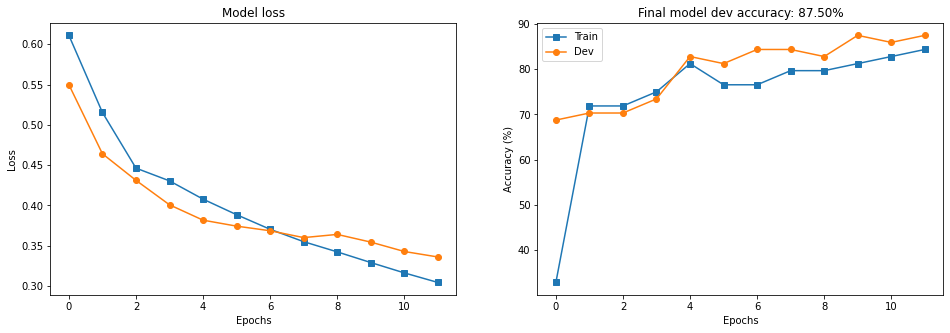

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLosses, "s-", label="Train")
ax[0].plot(devLosses, "o-", label="Dev")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, "s-", label="Train")
ax[1].plot(devAcc, "o-", label="Dev")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final model dev accuracy: {devAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [130]:
Y_pred = Gervasio(X_TEST_tensor)

female tensor([0.8713], grad_fn=<SelectBackward0>)


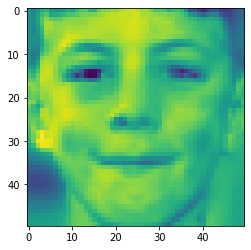

male tensor([0.3700], grad_fn=<SelectBackward0>)


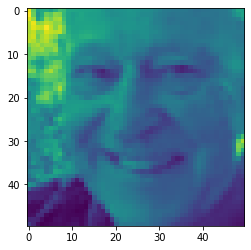

male tensor([0.0387], grad_fn=<SelectBackward0>)


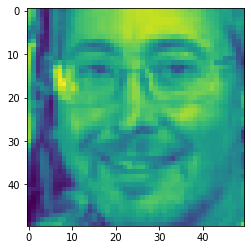

female tensor([0.8676], grad_fn=<SelectBackward0>)


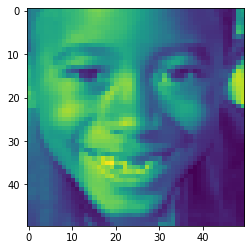

female tensor([0.8426], grad_fn=<SelectBackward0>)


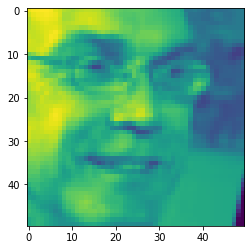

male tensor([0.4666], grad_fn=<SelectBackward0>)


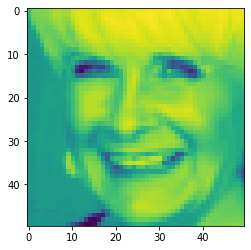

male tensor([0.4730], grad_fn=<SelectBackward0>)


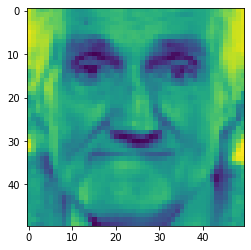

male tensor([0.1395], grad_fn=<SelectBackward0>)


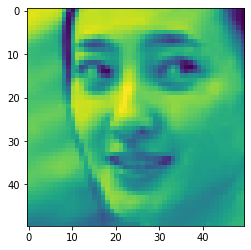

female tensor([0.9995], grad_fn=<SelectBackward0>)


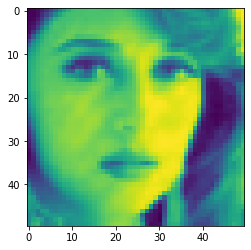

In [132]:
X_TEST = X_TEST.reshape(X_TEST.shape[0], 50, 50, 1)

for i in range(1, 10):
  if Y_pred[i] >= 0.5:
    print("female", Y_pred[i])
  else:
    print("male", Y_pred[i])
    
  plt.imshow(X_TEST[i])
  plt.show()
  time.sleep(1)